In [230]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# define matplotlib style
plt.style.use("classic")
mpl.rc("xtick", labelsize=23)
mpl.rc("ytick", labelsize=23)
mpl.rc("xtick.major", size=15, width=2)
mpl.rc("xtick.minor", size=8, width=2, visible=True)
mpl.rc("ytick.major", size=15, width=2)
mpl.rc("ytick.minor", size=8, width=2, visible=True)
mpl.rc("lines", linewidth=3, markersize=20)
mpl.rc("axes", linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc("legend", fontsize=25, loc="best", frameon=False, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [231]:
import numpy as np

In [248]:
from tidaldisruptionlrd import stellar_distribution, tde_rate
from tidaldisruptionlrd.constants import G

In [249]:
import importlib

importlib.reload(stellar_distribution)
importlib.reload(tde_rate)

<module 'tidaldisruptionlrd.tde_rate' from '/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/tde_rate.py'>

In [234]:
profile = stellar_distribution.SingularIsothermalSphereProfile(
    # M_s=1e1,
    r_bin_min=1e-4,
    r_bin_max=1e6,
    N_bins=10000,
    reduce_factor=10,
    N_trapz_bins=1000,
)

Calculating h(eps): 100%|██████████| 1000/1000 [01:08<00:00, 14.67it/s]


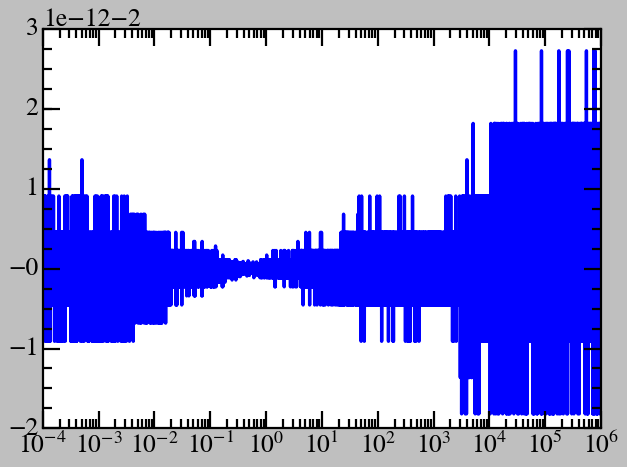

In [235]:
plt.plot(
    profile.r_bins,
    np.gradient(np.log(profile.stellar_rho_bins), np.log(profile.r_bins)),
)

plt.xscale("log")
# plt.yscale("log")

plt.tight_layout()
plt.show()

Reconstructing densities: 100%|██████████| 10000/10000 [00:10<00:00, 999.42it/s]


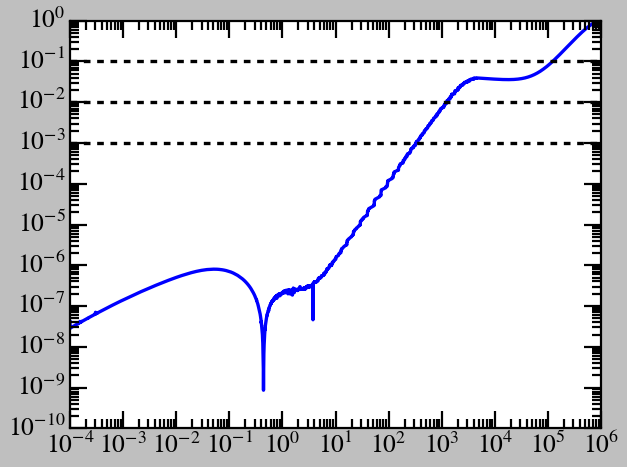

In [236]:
reconstructed_stellar_rho_bins = profile.reconstruct_stellar_rho_bins(
    -profile.phi_bins,
    profile.epsilon_bins,
    profile.g_epsilon_bins,
)

plt.plot(
    profile.r_bins,
    np.abs(1 - reconstructed_stellar_rho_bins / profile.stellar_rho_bins),
)

for tol in [1e-1, 1e-2, 1e-3]:
    plt.axhline(tol, color="k", ls="--")

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()

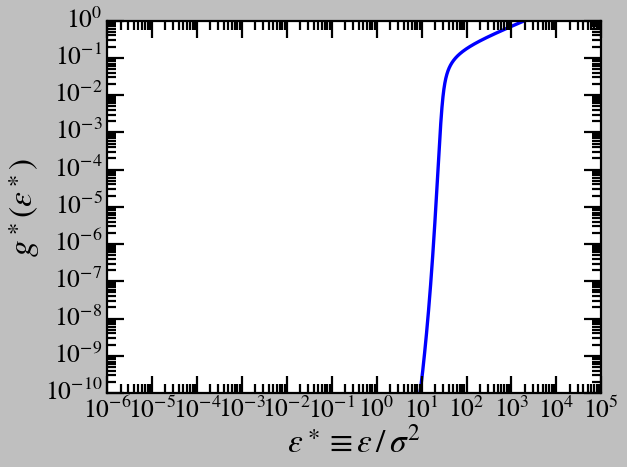

In [237]:
plt.plot(
    profile.epsilon_bins,
    profile.g_epsilon_bins,
)

plt.xscale("log")
plt.yscale("log")

# plt.xlim(0, 70)
plt.ylim(1e-10, 1e0)

plt.xlabel(r"$\epsilon^\ast \equiv \epsilon \, / \, \sigma^2$")
plt.ylabel(r"$g^\ast (\epsilon^\ast)$")

plt.tight_layout()
plt.show()

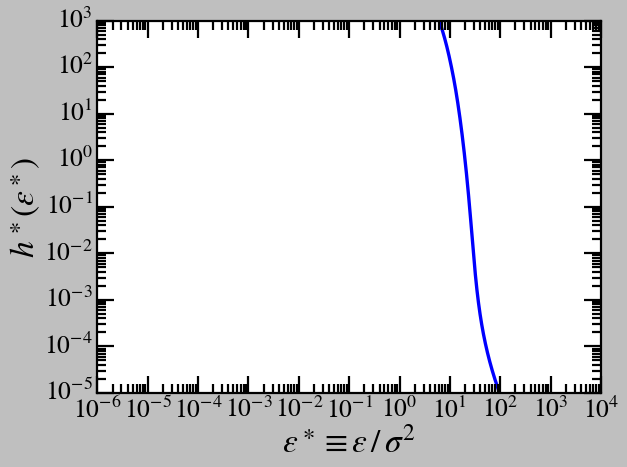

In [238]:
plt.plot(
    profile.reduced_epsilon_bins,
    profile.reduced_h_epsilon_bins,
)

plt.xscale("log")
plt.yscale("log")

# plt.xlim(0, 70)
plt.ylim(1e-5, 1e3)

plt.xlabel(r"$\epsilon^\ast \equiv \epsilon \, / \, \sigma^2$")
plt.ylabel(r"$h^\ast (\epsilon^\ast)$")

plt.tight_layout()
plt.show()

In [254]:
M_bh = np.logspace(6, 10, 100)
sigma = 200 * (M_bh / 1.48e8) ** (1 / 4.65)
# r_h = np.full_like(M_bh, 0.055 / profile.a)
r_h = G * M_bh / sigma**2
# r_h_const = G * M_bh / 100**2

tde = tde_rate.SingleMassTDERate(
    dimensionless_profile=profile,
    m_s_bins=np.linspace(0.08, 2, 1000),
    M_bhs=M_bh,
    r_hs=r_h,
)

# tde_const = tde_rate.SingleMassTDERate(
#     dimensionless_profile=isothermal_sphere_lc,
#     m_s_bins=np.linspace(0.08, 2, 1000),
#     M_bhs=M_bh,
#     r_hs=r_h_const,
# )

Calculating TDE rates: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


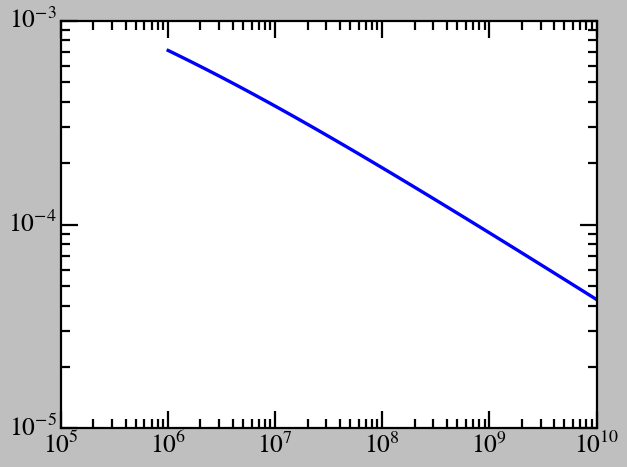

In [255]:
plt.plot(tde.M_bhs, tde.N_TDEs)
# plt.plot(tde_const.M_bhs, tde_const.N_TDEs)

plt.xscale("log")
plt.yscale("log")

# plt.xlim(1e4, 1e8)
# plt.ylim(1e-5, 1e0)

plt.tight_layout()
plt.show()